# MNIST Machine Learning Models

## Context

* MNIST is a subset of a larger set available from NIST (it's copied from http://yann.lecun.com/exdb/mnist/), primarily designed for supervised learning. The database of handwritten digits (i.e. clear labels) is comprised of 70,000 examples.

* The dataset was created as a testbed for development of handwriting recognition algorithms and machine learning classification algorithms in general by the US National Institute of Standards and Technology (NIST) originally, and later, AT&T Bell Labs.

* The instances in this dataset represent 28 x 28 gray-scale centered images of handwritten digits.

* NIST recommends a specific data-split with 60,000 for training, 10,000 for testing. The original NIST data was preprocessed by Yann LeCun and colleagues at AT&T Bell Labs and has no missing values.


## Load Necessary Libraries

In [69]:
import os

current_working_directory = os.getcwd()
print("Current working directory:", current_working_directory)

Current working directory: c:\Users\rshaw\Desktop\EC Utbildning - Data Science\Kurs 5 - Machine Learning\Kunskapkontroll2\Streamlit


In [70]:
from sklearn.datasets import fetch_openml

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

In [71]:
# Load MNIST data
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame = False)
print(mnist.DESCR)

c:\Users\rshaw\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

## Loading the Dataset

In [72]:
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

## EDA

In [73]:
# Checking the Shape, Datatype and Memory Usage of the dataset
print(f"Array Shape: {X.shape}")
print(f"Array Shape: {y.shape}")
print(f"Data Type: {X.dtype}")
memory_usage = X.nbytes / 1024 
print(f"Memory Usage: {memory_usage} KB")

Array Shape: (70000, 784)
Array Shape: (70000,)
Data Type: float64
Memory Usage: 428750.0 KB


In [74]:
print(X[:5, :])
print(y[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[5 0 4 1 9]


In [75]:
# Checking for missing values
missing_values_count = np.sum(np.isnan(X))
print(f"Missing Values Count: {missing_values_count}")

Missing Values Count: 0


In [76]:
# Creating a copy of the original data
X = X.copy()
y = y.copy()

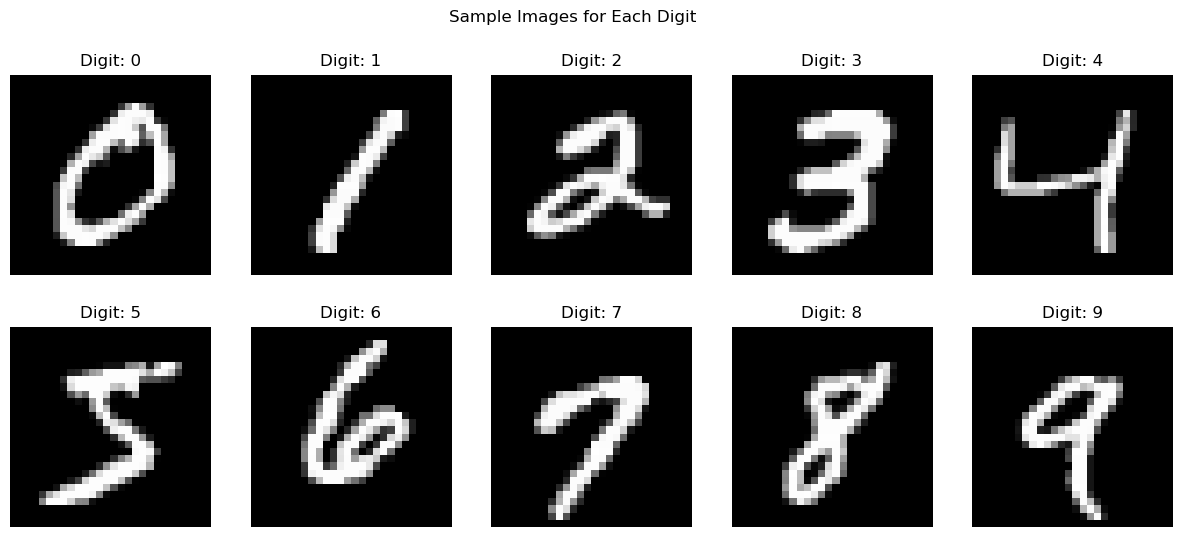

In [77]:
# Visualizing sample images to understand variability within classes, for our model to train on
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    idx = np.where(y == i)[0][0]  # Find the first occurrence of each digit
    img = X[idx].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Digit: {i}")
    ax.axis('off')
plt.suptitle("Sample Images for Each Digit")
plt.show()

Visually, these images are quite good but that said digits 4, 5, 6 and 9 appear a little bit skewed in style compared with the other 6 digits. For example, 4 is very wide in the top and could be confused with the letter "u" and 5 looks like the letter "s". This could require a more complex model to accurately predict the right image.

-- Data Augmentation: To improve the model's ability to correctly classify digits with ambiguous styles, data augmentation techniques such as scaling is a good idea, and we will target this in data preprocessing. 

-- Focused Training: Another strategy might be to include more examples of these potentially confusing digits in the training dataset or to use techniques like weighted loss functions to place more emphasis on correctly classifying digits that are more prone to confusion.

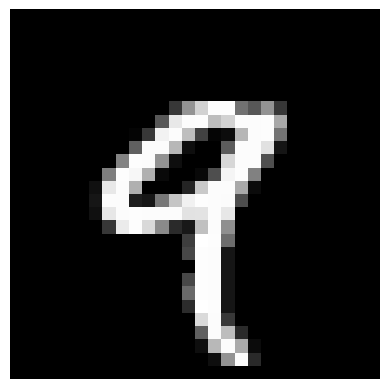

9


In [104]:
from matplotlib.colors import Normalize

sample_digit = X[4]
sample_digit_image = sample_digit.reshape(28, 28)
plt.imshow(sample_digit_image, cmap='gray', norm=Normalize(vmin=0, vmax=255), interpolation="nearest")
plt.axis("off")
plt.show()
print(y[4])  # Ensure the index matches the digit being displayed


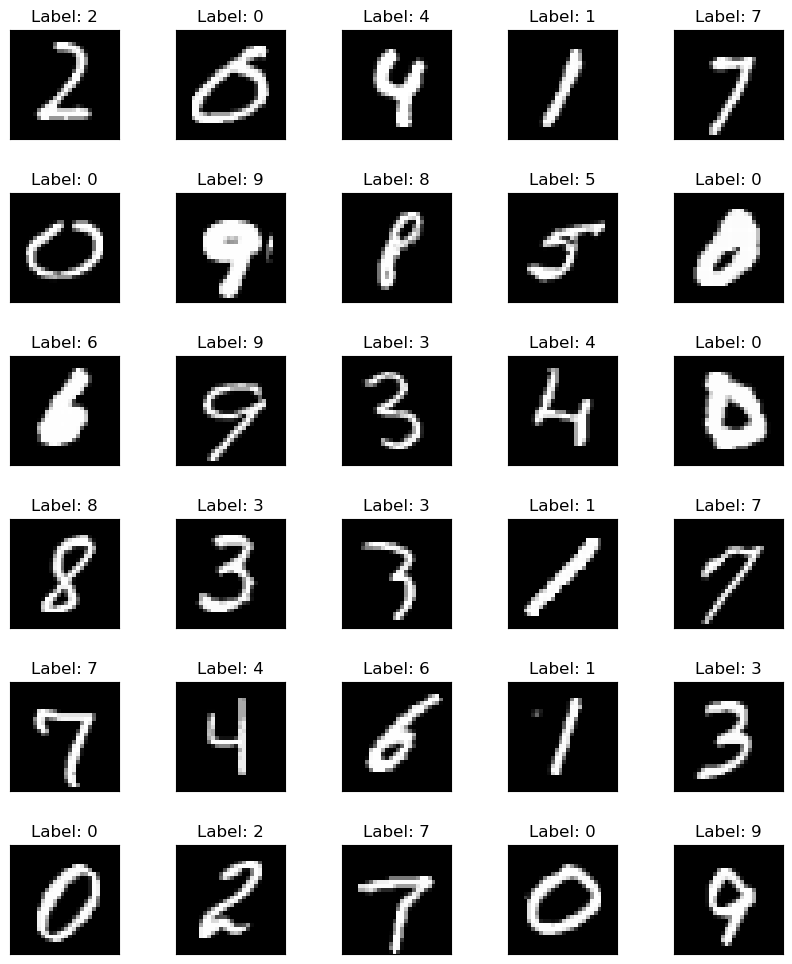

In [101]:
# Reshape the images from flattened arrays back to 2D (28x28 pixels)
images = X.reshape(-1, 28, 28)

# Select 30 samples randomly 
samples_index = np.random.choice(np.arange(len(images)), 30, replace=False)

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(10, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[samples_index[i]], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Label: {y[samples_index[i]]}")

plt.show()

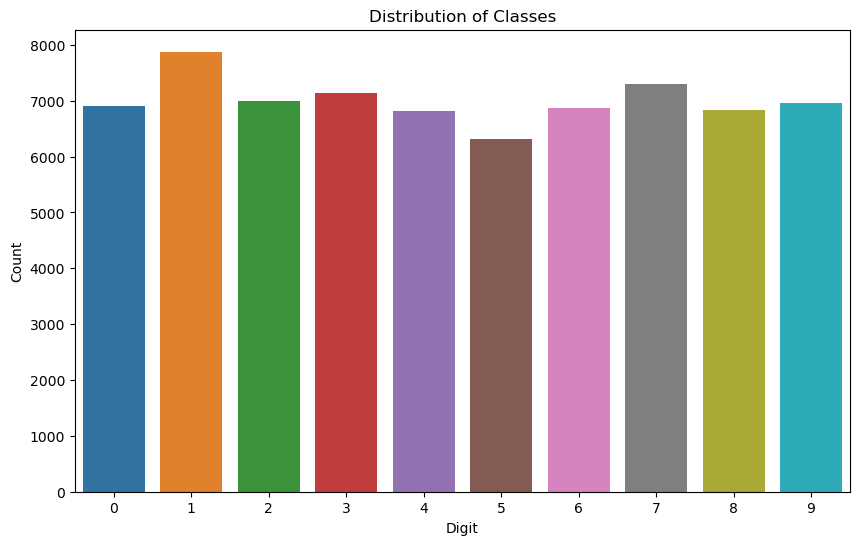

In [79]:
# Class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title('Distribution of Classes')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

These classes are relatively well balanced but there does seem to be a little bit of an imbalance with the digit 1 which has between 500 and 1000 more samples than the other 9 classes. 

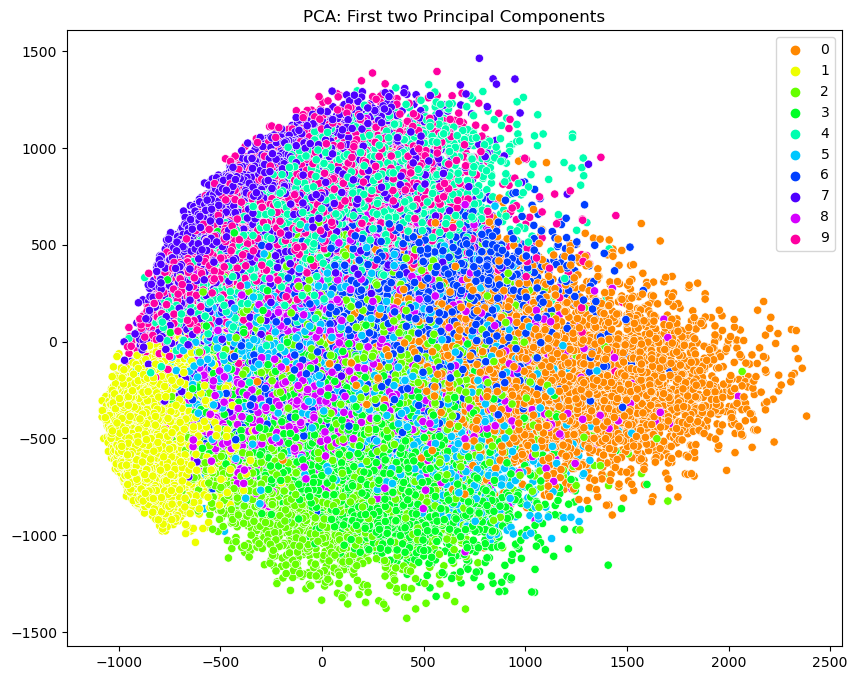

In [80]:
# PCA - Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=sns.color_palette("hsv", 10), legend="full")
plt.title('PCA: First two Principal Components')
plt.show()

Given the MNIST dataset is relatively clean and standardized without missing values, what we see here is more about using a reduced dimension to show us how the data is structured and where the dataset seems to form cleaner - distinct but not separate - groupings around certain images like 0 and 1, which can indicate a potential predisposition for these classes to be identified easier when we build our model.  

## Data Preprocessing

In [81]:
# First, split the data into a combined training + validation set and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42, stratify=y)

# Then, split the combined training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42, stratify=y_train_val)

# Check the sizes of the datasets
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Full_Training set size: {X_train_val.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (50000, 784)
Validation set size: (10000, 784)
Full_Training set size: (60000, 784)
Test set size: (10000, 784)


Here, we split the dataset into training, validation and testing. We use the stratify argument to keep the original class distribution in the target variable (y and y_train_val) while splitting the data into train, validation and test sets. This is important to keep the model's performance across these sets.

In [83]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data (do not fit the scaler again to avoid data leakage)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [84]:
#dump(pipeline, 'scaler_pca.joblib')
dump(scaler, 'scaler.joblib')

['scaler.joblib']

**Scaling**: Each image in the MNIST dataset is 28x28 pixels, which have been flattened into 784-dimensional vectors 
before scaling. Scaling is useful as a preprocessing step to improve the performance and training stability of many machine learning models - including Linear SVC, Random Forest, and KNN - by ensuring that all features contribute equally to the model's decision-making process.

**PCA for Dimensionality Reduction**: : Initially we ran PCA to help with computational speed but afterwards decided instead to reduce the sample sizes. In the case of MNIST, each of the 784 features represents a pixel value, and while individually these features might not be very informative, collectively they represent meaningful patterns. So the logic was that given the dataset is relatively balanced in terms of the number of features versus the number of samples, which helps in applying machine learning algorithms directly without the immediate need for dimensionality reduction. 

#### Reduce Sample Size for better computational resource handling

In [87]:
X_train_sampled = X_train_scaled[0:15000]
y_train_sampled = y_train[0:15000]

X_val_sampled = X_val_scaled[0:3000]
y_val_sampled = y_val[0:3000]

X_test_sampled = X_test_scaled[0:3000]
y_test_sampled = y_test[0:3000]

In [88]:
print(X_train_sampled.shape)
print(y_train_sampled.shape)

print(X_val_sampled.shape)
print(y_val_sampled.shape)

print(X_test_sampled.shape)
print(y_test_sampled.shape)

(15000, 784)
(15000,)
(3000, 784)
(3000,)
(3000, 784)
(3000,)


## Build Models

### Model Evaluation Criteria

The model can make wrong predictions as:
1. Predicting an image is a specific digit when it is not.
2. Predicting an image is not a specific digit when it is.

*Which case is more important?*
1. If the model predicts an image is not a certain digit but it is that digit, then the user (e.g. a passport office) would make a mistake which would affect their reputation.
2. If the model predicts an image is a certain digit but it is not then the user (e.g. a passport office) would also make a mistake which would affect their reputation.

*Which metric to optimize?*
- Both sides are equally important, so we would want F1-Score to be maximized, the greater the F1-Score higher the chances of predicting both the classes correctly.
- The MNIST dataset is a fundamental example of a multi-class classification problem in the field of machine learning, with its set of 10 different classes (digits 0-9) that a model needs to classify. We therefore use f1_macro as it calculates the F1 score independently for each class and then takes the average (hence treating all classes equally). This is useful to treat all classes equally and when the dataset may have class imbalance.

### Model 1 - LinearSVC

c:\Users\rshaw\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


c:\Users\rshaw\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy: 0.9557333333333333
Training F1 Score: 0.9548447282230462
Validation Accuracy Score: 0.8723333333333333
Validation F1 Score: 0.8701080844665968


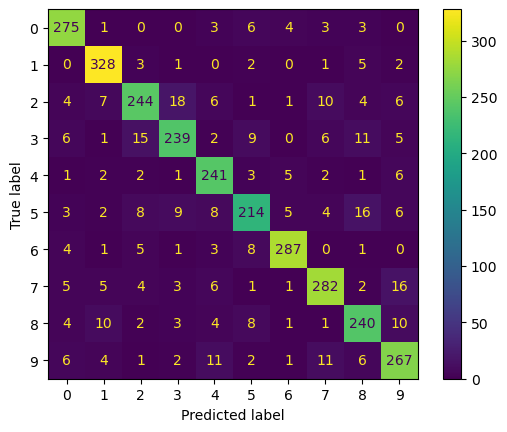

In [89]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_sampled, y_train_sampled)

# Make predictions on the training set
y_train_pred = lin_clf.predict(X_train_sampled)

# Calculate accuracy on the training set
train_accuracy =accuracy_score(y_train_sampled, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Calculate F1 score on the training set
train_f1 = f1_score(y_train_sampled, y_train_pred, average="macro")
print(f"Training F1 Score: {train_f1}")

# Make predictions on the validation set
y_val_pred = lin_clf.predict(X_val_sampled)

# Calculate accuracy on the validation set
val_accuracy = accuracy_score(y_val_sampled, y_val_pred)
print(f"Validation Accuracy Score: {val_accuracy}")

# Calculate F1 score on the validation set
val_f1 = f1_score(y_val_sampled, y_val_pred, average="macro")
print(f"Validation F1 Score: {val_f1}")

cm = confusion_matrix(y_val_sampled, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [114]:
# Save the Linear SVC model to disk
dump(lin_clf, 'SVC_model.joblib')

# Load the best model from disk for further predictions
SVC_Lin = load('SVC_model.joblib')

print(SVC_Lin)

LinearSVC(random_state=42)


#### Model 2 - KNN Classifier

Training Accuracy: 0.9464
Training F1 Score: 0.945990761604221
Validation Accuracy Score: 0.9233333333333333
Validation F1 Score: 0.9224521285614153


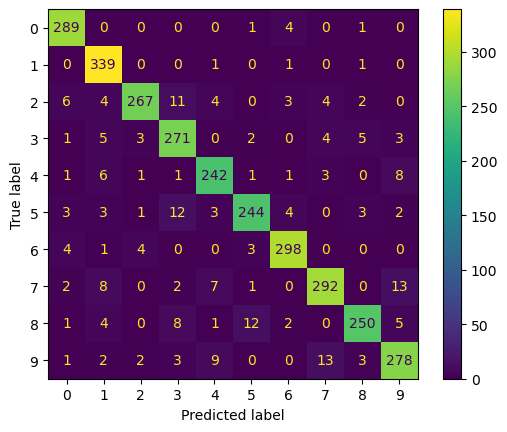

In [90]:
# Initialize the KNN model
knn_clf = KNeighborsClassifier(n_neighbors=5)  

# Fit the model to the training data
knn_clf.fit(X_train_sampled, y_train_sampled)

# Make predictions on the training set
y_train_pred = knn_clf.predict(X_train_sampled)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train_sampled, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Calculate F1 score on the training set
train_f1 = f1_score(y_train_sampled, y_train_pred, average="macro")
print(f"Training F1 Score: {train_f1}")

# Make predictions on the validation set
y_val_pred = knn_clf.predict(X_val_sampled)

# Calculate accuracy on the validation set
val_accuracy = accuracy_score(y_val_sampled, y_val_pred)
print(f"Validation Accuracy Score: {val_accuracy}")

# Calculate F1 score on the validation set
val_f1 = f1_score(y_val_sampled, y_val_pred, average="macro")
print(f"Validation F1 Score: {val_f1}")

# Calculate and visualize the confusion matrix for the validation set
cm = confusion_matrix(y_val_sampled, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Model 3 - Random Forest

Training Accuracy: 1.0
Training F1 Score: 1.0
Validation Accuracy Score: 0.9536666666666667
Validation F1 Score: 0.9530752012111737


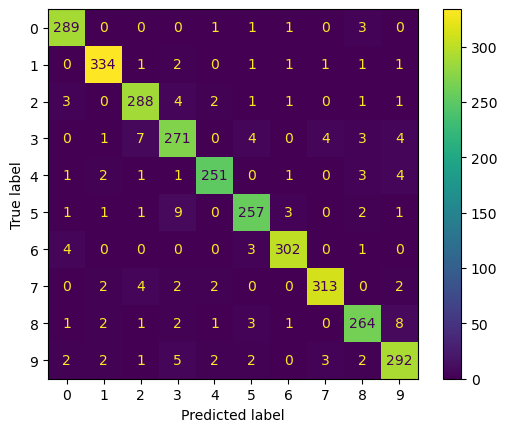

In [91]:
# Initialize the Random Forest model
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)  

# Fit the model to the training data
rf_clf.fit(X_train_sampled, y_train_sampled)

# Make predictions on the training set
y_train_pred = rf_clf.predict(X_train_sampled)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train_sampled, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Calculate F1 score on the training set
train_f1 = f1_score(y_train_sampled, y_train_pred, average="macro")
print(f"Training F1 Score: {train_f1}")

# Make predictions on the validation set
y_val_pred = rf_clf.predict(X_val_sampled)

# Calculate accuracy on the validation set
val_accuracy = accuracy_score(y_val_sampled, y_val_pred)
print(f"Validation Accuracy Score: {val_accuracy}")

# Calculate F1 score on the validation set
val_f1 = f1_score(y_val_sampled, y_val_pred, average="macro")
print(f"Validation F1 Score: {val_f1}")

# Calculate and visualize the confusion matrix for the validation set
cm = confusion_matrix(y_val_sampled, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Model 3a - Random Forest Tuned

c:\Users\rshaw\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Training Accuracy of the best model: 0.9998666666666667
Training F1 Score of the best model: 0.9998721883974812
Validation Accuracy of the best model: 0.9586666666666667
Validation F1 Score of the best model: 0.9583311547026051
Best parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 20}
Best training score from CV for Random Forest: 0.9545736508340547


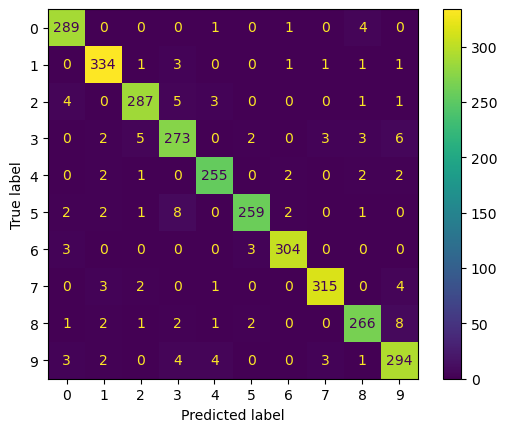

In [92]:
# Define the model
rf_clf_tuned = RandomForestClassifier(random_state=42)

# Setup the parameters and distributions to sample 
param_dist = {
    'n_estimators': [200, 300], # Tried 100, 200 first
    'max_depth': [20, 30],      # Tried 10, 20 first
    'min_samples_split': [2]    # Tried 1, 2 and 5 first
}

# Instantiate a Random Forest classifier with n_iter set to 10
rf_random_search = RandomizedSearchCV(rf_clf_tuned, param_distributions=param_dist, n_iter=10, cv=3, scoring='f1_macro', random_state=42, n_jobs=-1, verbose=2)

# Fit the model
rf_random_search.fit(X_train_sampled, y_train_sampled)

# Make predictions on the training set
y_train_pred = rf_random_search.best_estimator_.predict(X_train_sampled)

# Evaluate the best model on the training set
train_accuracy = accuracy_score(y_train_sampled, y_train_pred)
train_f1 = f1_score(y_train_sampled, y_train_pred, average='macro')

print(f"Training Accuracy of the best model: {train_accuracy}")
print(f"Training F1 Score of the best model: {train_f1}")

# Use the best estimator to make predictions on the validation set
y_val_pred = rf_random_search.best_estimator_.predict(X_val_sampled)

# Evaluate the best model on the validation set
val_accuracy = accuracy_score(y_val_sampled, y_val_pred)
val_f1 = f1_score(y_val_sampled, y_val_pred, average='macro')

print(f"Validation Accuracy of the best model: {val_accuracy}")
print(f"Validation F1 Score of the best model: {val_f1}")
print("Best parameters for Random Forest:", rf_random_search.best_params_)
print("Best training score from CV for Random Forest:", rf_random_search.best_score_)

# Calculate and visualize the confusion matrix for the validation set
cm = confusion_matrix(y_val_sampled, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Model 2a - KNN Classifier Tuned

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best score: 0.921381229265139
Training Accuracy: 1.0
Training F1 Score: 1.0
Validation Accuracy Score: 0.9303333333333333
Validation F1 Score: 0.9295182883229518


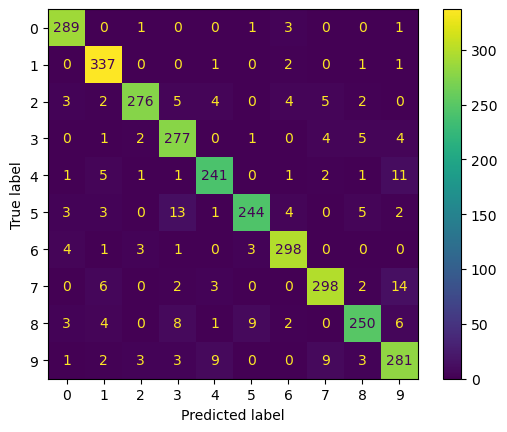

In [93]:
# Initialize the KNN model
knn_clf_tuned = KNeighborsClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': [2, 3],    #Tried 3, 5, 7, 9 first
    'weights': ['distance'],  #Tried 'uniform', 'distance' first
    'metric': ['euclidean']   #Tried 'euclidean', 'manhattan' first
}

# Setup GridSearchCV
knn_grid_search = GridSearchCV(estimator=knn_clf_tuned, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)

# Fit the model to the training data
knn_grid_search.fit(X_train_sampled, y_train_sampled)

# Print the best parameters and the best score
print("Best parameters:", knn_grid_search.best_params_)
print("Best score:", knn_grid_search.best_score_)

# Use the best estimator to make predictions
y_train_pred = knn_grid_search.best_estimator_.predict(X_train_sampled)
y_val_pred = knn_grid_search.best_estimator_.predict(X_val_sampled)

# Calculate and print accuracy and F1 score for training set
train_accuracy = accuracy_score(y_train_sampled, y_train_pred)
train_f1 = f1_score(y_train_sampled, y_train_pred, average="macro")
print(f"Training Accuracy: {train_accuracy}")
print(f"Training F1 Score: {train_f1}")

# Calculate and print accuracy and F1 score for validation set
val_accuracy = accuracy_score(y_val_sampled, y_val_pred)
val_f1 = f1_score(y_val_sampled, y_val_pred, average="macro")
print(f"Validation Accuracy Score: {val_accuracy}")
print(f"Validation F1 Score: {val_f1}")

# Calculate and visualize the confusion matrix for the validation set
cm = confusion_matrix(y_val_sampled, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Save RF-tuned model

In [106]:
# Save the best model to disk
dump(rf_random_search.best_estimator_, 'RF_model.joblib')

# Load the best model from disk for further predictions
RF_best_loaded = load('RF_model.joblib')

print(RF_best_loaded)

RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42)


## Evaluate on Best Model - RF Tuned Classifier model

In [107]:
# Make predictions on the test set with the loaded model
y_pred = RF_best_loaded.predict(X_test_sampled)
print(RF_best_loaded.__class__.__name__)
print(classification_report(y_test_sampled, y_pred))

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       305
           1       0.97      0.98      0.98       352
           2       0.96      0.92      0.94       291
           3       0.96      0.92      0.94       289
           4       0.96      0.93      0.95       288
           5       0.95      0.97      0.96       267
           6       0.95      0.99      0.97       278
           7       0.95      0.96      0.95       301
           8       0.96      0.96      0.96       313
           9       0.91      0.91      0.91       316

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



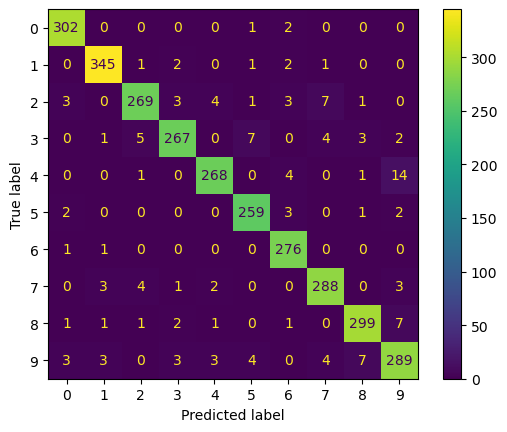

In [115]:
cm = confusion_matrix(y_test_sampled, y_pred, labels=RF_best_loaded.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=RF_best_loaded.classes_)
disp.plot()
plt.show()

## Summary & Analysis

SUMMARY
* The Mnist dataset has is generally very well organized and clean without missing values. It has a balanced array of features (and samples), so we scaled them to set up the data (features) better for modelling.
* Through EDA, we also noticed that many of the target labels, i.e. the digits have a significant variance in size and shape, which could make it more difficult for certain models to handle. Together with this, there was a slight unbalance in the classes, particularly for the class/digit 1.
* After having run the first two models, we noticed that the run times were taking very long (over 2 hours), so we went back to the preprocessing stage and reduced the sample sets accordingly.
* In terms of model evaluation, we picked the f1-score metric given the academic context's goal to create both a model and an app that would equally predict whether a digit is a False Negative or False Positive. 
* For model selection, we used https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html - as well as other referenced material documented in our report - to select three classifier models, namely Linear SVC, KNN and Random Forest. The best model on test data was a hyper-tuned version of the Random Forest model.

ANALYSIS 
* Our baseline Linear SVC model had an F1 Score of 87% on the validation set. It had a particular problem predicting 4 digits, in particular with 7s as 9s getting 16 wrong estimations. We decided to move on with validating a K Nearest Neighbors (KNN) model.

* The KNN model did quite well on the training data with an f1 score of close to 95%, and generalized quite well to the validation data to just over 92%. It certainly didn't seem to overfit or underfit. It did do a bit better with the troublesome 7s as 9s and had notable problems with 2 digits. Finally, we decided to see if the powerful Random Forest model with a baseline of 100 Decision Trees could generalize better.

* The Random Forest model scored perfectly on the training data with an f1 score of 100%, but still also generalized well to the validation data scoring just over 95%. It seems to be overfitting, which is often the case with Random Forest models. It had notable problems with 3 digits in particular. 

* Based on this, we decided to drop the SVM model and move forward with GridSearchCV HyperParameter tuning on the KNN and Random Forest models. GridsearchCV took too long on the Random Forest model so we changed to a RandomizedSearch. Both models did better, with the RF tuned model overfitting less and rising by almost 1% to just under 96% and the KNN tuned model rising by almost 1% to just under 93%. So we decided to go with the Random Forest tuned model.
